In [405]:
# Import libraries
%load_ext autoreload
%autoreload 2

# from pulse_lib.pickle_parse import *
# from pulse_lib.phase_calibration import *

from qick import *
import Pyro4
import pickle
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
out_chs = [0,1]
print(soccfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback

In [406]:
# TODO: Make this a user-defined numpy array
f0_start=100
f0_step=1
expts=100
# expts=1

f0_v = np.arange(0,expts)*f0_step+f0_start
f0_v = soccfg.adcfreq(f0_v, gen_ch=0, ro_ch=0)

def calculate_phase(d):
    [xi,xq] = d
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.mean(x)

    # Calculate calibration phase.
    fi = np.remainder(np.angle(xavg,deg=True)+360,360)
    return [fi, np.abs(xavg), np.std(x)]

# TODO: Redundant function?
def print_results(res):
    print("freq_i = %f MHz, "%(f0) +
         "phi_i = (%.2f, %.2f) deg, " % tuple([res[i][0] for i in range(2)]) +
         "mag = (%.2f, %.2f), " % tuple([res[i][1] for i in range(2)]) +
         "RMS = (%.2f, %.2f) ADU" % tuple([res[i][2] for i in range(2)]))
#     print("freq_i = %f MHz, phi_i = (%.2f, %.2f) deg, mag = (%.2f, %.2f), RMS = (%.2f, %.2f) ADU" %(f0,*out_array,*A,*xrms))

In [407]:
# TODO: Remove unnecessary function calls
# TODO: Move outside of notebook
class SingleFreqProgram(AveragerProgram):
    def __init__(self,soccfg, cfg):
        super().__init__(soccfg, cfg)

    def initialize(self):
        cfg=self.cfg   
        
        # configure the readout lengths and downconversion frequencies
        for ch in range(2):
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"])

        idata = 30000*np.ones(16*cfg["length"])

        for ch in self.cfg['out_ch']:
            self.declare_gen(ch=ch, nqz=1)
            self.add_pulse(ch=ch, name="measure", idata=idata)
        
        freq=soccfg.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency
        self.trigger(pins=[0], t=0) # send a pulse on pmod0_0, for scope trigger
        for ch in self.cfg['out_ch']:
            self.set_pulse_registers(ch=ch, style="arb", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"], 
                                     waveform="measure", mode="periodic")

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, t=0) # play readout pulse
        self.wait_all() # control should wait until the readout is over
        self.sync_all(200)  # wait for measurement to complete

config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "res_phase":soccfg.deg2reg(0), # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

## ADC_D

In [408]:
# TODO: Remove near-duplicate cells
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
res=[]
adc_d_offsets = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    adc_d_offsets[f0] = res[-1][0][0]
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

print(adc_d_offsets)

{100.00000991821288: 168.88894869317528, 101.00000610351562: 150.91372888344176, 102.00000228881835: 132.93272236391567, 102.99999847412109: 114.94881410039329, 103.99999465942382: 96.96267950474379, 104.99999084472655: 78.97599900532748, 106.00000762939452: 60.66713867694932, 107.00000381469725: 42.67434932658256, 107.99999999999999: 24.67999695191031, 108.99999618530272: 6.685211564295628, 109.99999237060545: 348.6880797474007, 111.00000915527343: 330.36827089354455, 112.00000534057617: 312.36451200916525, 113.0000015258789: 294.3611707054936, 113.99999771118163: 276.3586608361341, 114.99999389648437: 258.35377705249647, 115.9999900817871: 240.34458556753924, 117.00000686645507: 222.0150297604598, 118.0000030517578: 204.00113988316966, 118.99999923706054: 185.9911969274575, 119.99999542236327: 167.97690115698492, 120.999991607666: 149.96406863461596, 122.00000839233397: 131.62773259534072, 123.0000045776367: 113.61046034838773, 124.00000076293944: 95.59352865039938, 124.9999969482421

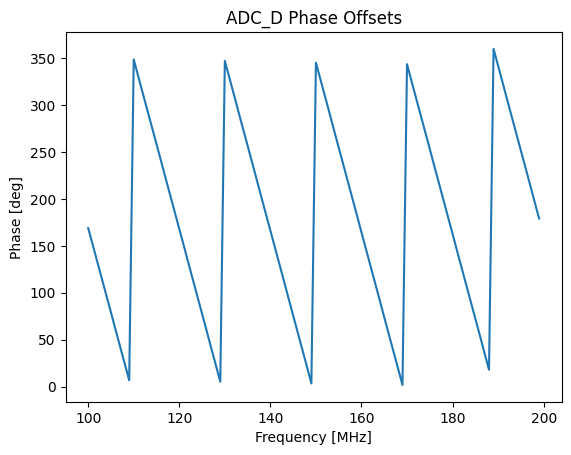

In [409]:
x, y = [], []
for key, value in adc_d_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x, y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_D Phase Offsets");

## ADC_C

In [410]:
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
res=[]
adc_c_offsets = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    adc_c_offsets[f0] = res[-1][1][0]
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

print(adc_c_offsets)

{100.00000991821288: 168.11746476807707, 101.00000610351562: 150.15083406590782, 102.00000228881835: 132.18487502575147, 102.99999847412109: 114.21430178957252, 103.99999465942382: 96.2433577531583, 104.99999084472655: 78.27226775992665, 106.00000762939452: 59.97241148274264, 107.00000381469725: 41.98882435428834, 107.99999999999999: 24.001547995799115, 108.99999618530272: 6.01602036904643, 109.99999237060545: 348.0257749768302, 111.00000915527343: 329.7152262262332, 112.00000534057617: 311.72153065281464, 113.0000015258789: 293.7271199617238, 113.99999771118163: 275.7291733638703, 114.99999389648437: 257.72999395290253, 115.9999900817871: 239.72824870054737, 117.00000686645507: 221.40778452840757, 118.0000030517578: 203.40163827453128, 118.99999923706054: 185.39531144826876, 119.99999542236327: 167.38910948169485, 120.999991607666: 149.37976472715172, 122.00000839233397: 131.05190206848647, 123.0000045776367: 113.04143452215067, 124.00000076293944: 95.02953213215858, 124.9999969482421

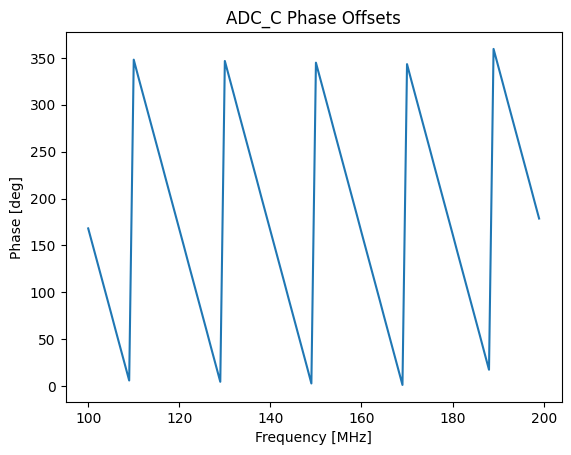

In [411]:
x, y = [], []
for key, value in adc_c_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(adc_c_x,adc_c_y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_C Phase Offsets");

In [412]:
adc_offsets = {}

for freq in adc_c_offsets:
    adc_offsets[freq] = ((adc_c_offsets[freq] - adc_d_offsets[freq]) % 360) - 360

# print(adc_offsets)

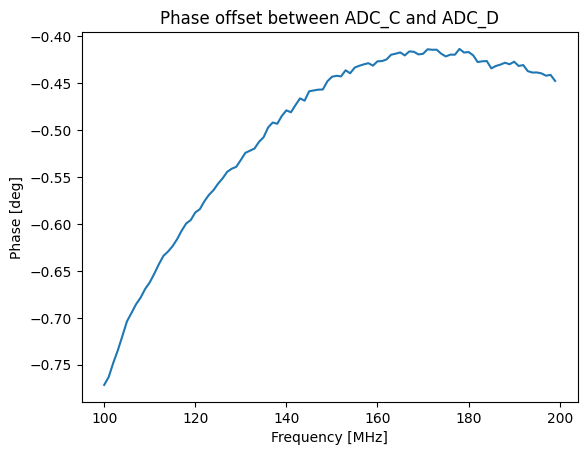

In [413]:
x,y = [], []
for key, value in adc_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("Phase offset between ADC_C and ADC_D");

## Calibrate Phase

In [415]:
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
res=[]
delta_phis = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    delta_phis[f0] = [(res[-1][0][0] - res[-1][1][0] + adc_offsets[f0]) % 360, 0]
    # print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

# print(res)
# adc_c_phi = res[0][1][0]
# adc_d_phi = res[0][0][0]
# adc_d_phi_corrected = adc_d_phi + adc_offset
# delta_phi = (adc_c_phi - adc_d_phi_corrected) % 360
# print(delta_phi)
print(delta_phis)

{100.00000991821288: [335.8893210429453, 0], 101.00000610351562: [332.04153294789717, 0], 102.00000228881835: [328.1982194430251, 0], 102.99999847412109: [324.352165138282, 0], 103.99999465942382: [320.5072261936058, 0], 104.99999084472655: [316.66146270333184, 0], 106.00000762939452: [312.80843035671086, 0], 107.00000381469725: [308.9545961748037, 0], 107.99999999999999: [305.099173399246, 0], 108.99999618530272: [301.2514239409826, 0], 109.99999237060545: [297.4039260430664, 0], 111.00000915527343: [293.556064325113, 0], 112.00000534057617: [289.7133933794594, 0], 113.0000015258789: [285.87002115059636, 0], 113.99999771118163: [282.0236543181397, 0], 114.99999389648437: [278.17837224579404, 0], 115.9999900817871: [274.3342846213111, 0], 117.00000686645507: [270.4907206302196, 0], 118.0000030517578: [266.64671826802817, 0], 118.99999923706054: [262.7993326048859, 0], 119.99999542236327: [258.95672503330604, 0], 120.999991607666: [255.108276835423, 0], 122.00000839233397: [251.26583456

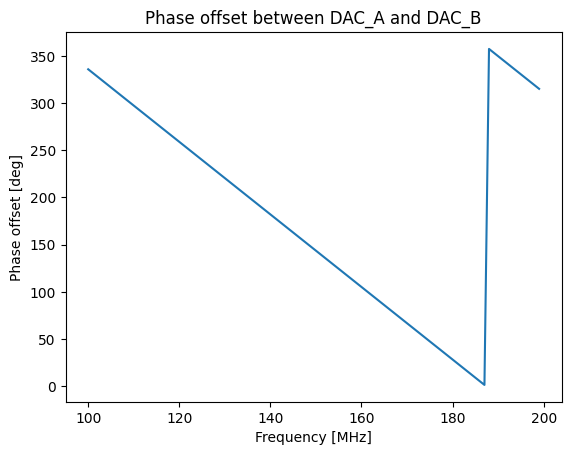

In [417]:
x,y = [], []
for key, value in delta_phis.items():
    x.append(key)
    y.append(value[0])

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [418]:
# to save the data
with open('pickles/calibrate_phase.pickle', 'wb') as handle:
    pickle.dump(delta_phis, handle, protocol=pickle.HIGHEST_PROTOCOL)